In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
def age_category(x):
    categories = ['young_child', 'child', 'adult', 'senior', 'Unknown', 'ERROR']
    x_mapped = np.where(x.isna(), 'Unknown', 
                        np.where(x < 12, 'young_child', 
                                 np.where(x < 18, 'child', 
                                          np.where(x < 50, 'adult',
                                                   np.where(x >= 50, 'senior', 'ERROR')
                                                  )
                                         )
                                )
                       )
    return pd.Categorical(x_mapped, ordered=True, categories=categories)

In [3]:
df = (pd.read_csv(r'data/train.csv')
      .set_index('PassengerId')
      .rename(columns=str.lower)
      .assign(
          age_category=lambda x: age_category(x.age),
          family_size=lambda x: x.sibsp + x.parch,
          is_alone=lambda x: (x.family_size == 0).astype('int'),
          fare_bins =lambda x: pd.qcut(x.fare, 4),
      )
     )

In [4]:
""" Check for duplicates """
assert(not df.duplicated(keep=False).any())

## Overall Survival Rate

In [5]:
print('{:.2%}'.format(df.survived.mean()))

38.38%


## Survival Rate

In [6]:
def survival_rate(input_df, dims, include_totals=False, format_rate=True):
    df = input_df.copy()
    df = (df.groupby(dims)
          .agg(
              total_passengers=pd.NamedAgg(column='survived', aggfunc='count'),
              number_survived=pd.NamedAgg(column='survived', aggfunc='sum'),
          )
          .assign(
              number_died=lambda x: x.total_passengers-x.number_survived,
              survival_rate=lambda x: x.number_survived.div(x.total_passengers)
          )
         )
    if format_rate:
        df = df.assign(survival_rate=lambda x: x.survival_rate.map("{:.1%}".format))
    
    if include_totals:
        return df
    return df.drop(['total_passengers', 'number_survived', 'number_died'], axis=1)

In [7]:
df.pipe(survival_rate, 'pclass', False)

,survival_rate
pclass,
1,63.0%
2,47.3%
3,24.2%


In [8]:
df.pipe(survival_rate, ['sex', 'pclass'], True).unstack('sex')

total_passengers      number_survived      number_died      survival_rate       
sex              female male          female male      female male        female   male
pclass                                                                                 
1                    94  122              91   45           3   77         96.8%  36.9%
2                    76  108              70   17           6   91         92.1%  15.7%
3                   144  347              72   47          72  300         50.0%  13.5%

Clearly your class affects who survives

In [9]:
df.pipe(survival_rate, ['sex', 'age_category'], True).unstack('sex')

total_passengers      number_survived       number_died        survival_rate       
sex                    female male          female  male      female   male        female   male
age_category                                                                                    
young_child                32   36            19.0  20.0        13.0   16.0         59.4%  55.6%
child                      23   22            19.0   3.0         4.0   19.0         82.6%  13.6%
adult                     184  343           139.0  63.0        45.0  280.0         75.5%  18.4%
senior                     22   52            20.0   7.0         2.0   45.0         90.9%  13.5%
Unknown                    53  124            36.0  16.0        17.0  108.0         67.9%  12.9%
ERROR                       0    0             NaN   NaN         NaN    NaN          nan%   nan%

## Age

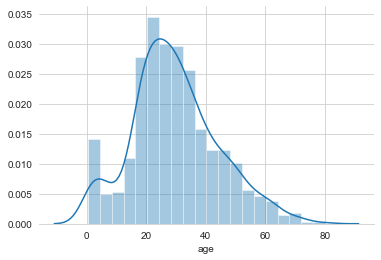

In [10]:
sns.distplot(df.age.dropna())
sns.despine(left=True)

## Title

In [11]:
""" Add title """
pat = r'[\w\s\'-]+, ([\w\s]+)\. [\w\(\)\"\s\'-]+'
assert(df.name.str.match(pat).all() == True)
df = df.assign(title=lambda x: x.name.str.extract(pat))

In [12]:
df.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [13]:
pd.concat([
    df.groupby('title').survived.mean().sort_values(ascending=False),
    df.title.value_counts()
], axis=1)

,survived,title
the Countess,1.000000,1
Mlle,1.000000,2
Lady,1.000000,1
Ms,1.000000,1
Sir,1.000000,1
Mme,1.000000,1
Mrs,0.792000,125
Miss,0.697802,182
Master,0.575000,40
Major,0.500000,2


In [14]:
"""
We are using a data structure of dictionaries with keys --> lists for title_groups --> titles
and flipping it as it is easier to keep track
I know this creates extra work but the organization is worth it
"""
title =  {
    'Rare': ['the Countess', 'Mlle', 'Lady', 'Sir', 'Mme', 'Jonkheer', 'Don'],
    'Miss': ['Ms', 'Miss'],
    'Mrs': ['Mrs'],
    'Master': ['Master'],
    'Army': ['Major', 'Col',],
    'Navy': ['Capt'],
    'Religious': ['Rev'],
    'Medical': ['Dr'],
    'Mr': ['Mr']
    }
title_map = {}
for title_group, title_list in title.items():
    for title in title_list:
        title_map[title] = title_group
assert(df.title.drop_duplicates().loc[df.title.drop_duplicates().map(title_map).isna(), ].empty == True)

In [15]:
df = df.assign(title=lambda x: x.title.map(title_map))

## Class

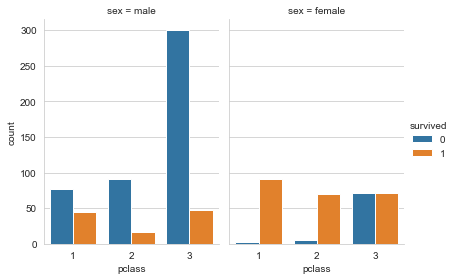

In [16]:
sns.catplot(x="pclass", hue="survived", col="sex",
            data=df, kind="count",
            height=4, aspect=.7)
plt.show()

If you're a male in third class, you are f*'d. If you're a female in third class, it's a coin toss.

## Parch

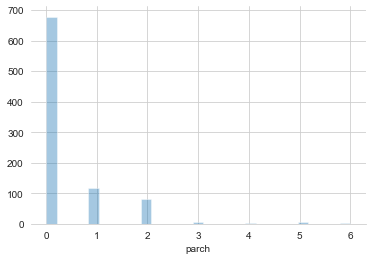

In [17]:
sns.distplot(df.parch.dropna(), kde=False)
sns.despine(left=True)

## Sex

In [18]:
sex_map = {'male': 0, 'female': 1}
df.loc[:, 'sex'] = df.loc[:, 'sex'].map(sex_map)

## Fare by Classes

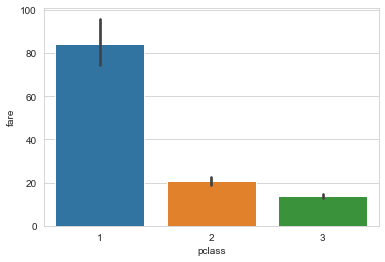

In [19]:
ax = sns.barplot(x="pclass", y="fare", data=df)
plt.show()

First class was between \\$75 and \\$100.
Second class was \\$20 and third class was about \\$10.

## Fare by Classes Adjusted for Inflation

In [20]:
df = df.assign(fare_today=lambda x: x.fare * 26.07)

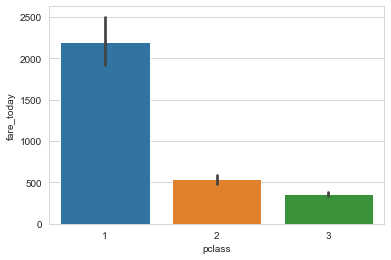

In [21]:
ax = sns.barplot(x="pclass", y="fare_today", data=df)
plt.show()

First class was between \\$2,000 and \\$2,500.
Second class was \\$500 and third class was about \\$250. About the cost of a flight.

[Sourced from the Inflation Calculator](https://www.usinflationcalculator.com/)

## Title

In [22]:
x = df.title
title_le = preprocessing.LabelEncoder()
title_le.fit(x)
df.loc[:, 'title'] = title_le.transform(x)

## Embarked

In [23]:
df.loc[df.embarked.isna(), 'embarked']

PassengerId
62     NaN
830    NaN
Name: embarked, dtype: object

In [24]:
df.loc[:, 'embarked'] = df.loc[:, 'embarked'].fillna(df.embarked.mode().values[0])

In [25]:
x = df.embarked
embarked_le = preprocessing.LabelEncoder()
embarked_le.fit(x)
df.loc[:, 'embarked'] = embarked_le.transform(x)

In [26]:
def le_map(le):
    classes = le.classes_
    labels = le.transform(le.classes_)
    return dict(zip(classes, labels))

## Fare Bins

In [27]:
column = 'survived'
df.loc[df.loc[:, column].isna(), column]

Series([], Name: survived, dtype: int64)

In [28]:
columns_to_be_encoded = 'fare_bins'
x = df.loc[:, columns_to_be_encoded]
fare_le = preprocessing.LabelEncoder()
fare_le.fit(x)
df.loc[:, columns_to_be_encoded] = fare_le.transform(x)

## Age Category

In [29]:
columns_to_be_encoded = 'age_category'
x = df.loc[:, columns_to_be_encoded]
age_le = preprocessing.LabelEncoder()
age_le.fit(x)
df.loc[:, columns_to_be_encoded] = age_le.transform(x)

## Random Forest

In [30]:
ivars = ['pclass', 'sex', 'fare_bins', 'title', 'embarked', 'family_size', 'is_alone',]
X = df.loc[:, ivars]
mask = X.loc[:, ivars].isna().any(axis=1)
assert(X.loc[mask, ].empty)

In [31]:
dvar = 'survived'
ivars = ['pclass', 'sex', 'title', 'embarked', 'family_size', 'is_alone', 'age_category']
y = df.loc[:, dvar].ravel()
X = df.loc[:, ivars]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
""" Accuracy Score without fare_bins """
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8203389830508474

In [35]:
""" Accuracy Score with fare_bins """
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8203389830508474

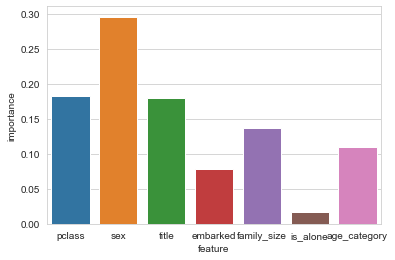

In [36]:
feature_importances = []
for feature, importance in dict(zip(X.columns.tolist(), rf.feature_importances_)).items():
    row = {}
    row['feature'] = feature
    row['importance'] = importance
    feature_importances.append(row)
data = pd.DataFrame.from_dict(feature_importances)
sns.barplot(x='feature', y='importance', data=data)
plt.show()

In [37]:
import pickle

filename = 'titanic_model.pkl'
with open(filename, 'wb') as f:
    pickle.dump(rf, f)